## Message Passing Layers

In [1]:
%matplotlib inline
from typing import List, Tuple, Sequence
from matplotlib import pyplot as plt
from mpnn.data import make_tfrecord
from mpnn.layers import Scaling
from sklearn.model_selection import train_test_split
from rdkit import Chem
from tqdm import tqdm
from functools import partial
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import tensorflow as tf
import pandas as pd
import numpy as np
import networkx as nx
import json

Downloading QM9 dataset and converting SMILES molecules to RDKit molecules w/ hydrogens:

In [2]:
%%time
data = pd.read_json('../datasets/qm9.json.gz', lines=True)
data ['mol'] = data['smiles_0'].apply(Chem.MolFromSmiles).apply(Chem.AddHs)

CPU times: total: 3.84 s
Wall time: 3.84 s


#### Preprocessing!

Converting types of atoms and bonds to numerical values: 

In [3]:
# identifying all possible atom and bond types in dataset

def make_type_lookup_tables(mols: List[Chem.Mol]) -> Tuple[List[int], List[str]]:
    """Create lists of observed atom and bond types

    Args:
        mols: List of molecules used for our training set
    Returns:
        - List of atom types (elements)
        - List of bond types (elements)
    """

    # Initialize the lists
    atom_types = set()
    bond_types = set()

    # Get all types observed in these graphs
    for mol in mols:
        atom_types.update([x.GetAtomicNum() for x in mol.GetAtoms()])
        bond_types.update([x.GetBondType() for x in mol.GetBonds()])

    # Return as sorted lists
    return sorted(atom_types), sorted(bond_types)

Creating an extensive dictionary consisting of atom types, bond types, and the specific atoms that are connected by particular bonds:   

In [4]:
# converting atom and bond features in a dictionary/array

def convert_mol_to_dict(mol: Chem.Mol, atom_types: List[int], bond_types: List[str]) -> dict:
    """Convert RDKit representation of a molecule to an MPNN-ready dict
    
    Args:
        mol: Molecule to be converted
        atom_types: Lookup table of observed atom types
        bond_types: Lookup table of observed bond types
    Returns:
        (dict) Molecule as a dict
    """

    # Get the atom types, look them up in the atom_type list
    atom_type = [a.GetAtomicNum() for a in mol.GetAtoms()]
    atom_type_id = list(map(atom_types.index, atom_type))

    # Get the bond types and which atoms these connect
    connectivity = []
    edge_type = []
    for bond in mol.GetBonds():
        # Get information about the bond
        a = bond.GetBeginAtomIdx()
        b = bond.GetEndAtomIdx()
        b_type = bond.GetBondType()
        
        # Store how they are connected
        connectivity.append([a, b])
        connectivity.append([b, a])
        edge_type.append(b_type)
        edge_type.append(b_type)
    edge_type_id = list(map(bond_types.index, edge_type))

    # Sort connectivity array by the first column
    #  This is needed for the MPNN code to efficiently group messages for
    #  each atom when performing the message passing step
    connectivity = np.array(connectivity)
    if connectivity.size > 0:
        # Skip a special case of a molecule w/o bonds
        inds = np.lexsort((connectivity[:, 1], connectivity[:, 0]))
        connectivity = connectivity[inds, :]

        # Tensorflow's "segment_sum" will cause problems if the last atom
        #  is not bonded because it returns an array
        if connectivity.max() != len(atom_type) - 1:
            smiles = convert_nx_to_smiles(graph)
            raise ValueError(f"Problem with unconnected atoms for {smiles}")
    else:
        connectivity = np.zeros((0, 2))

    return {
        'n_atom': len(atom_type),
        'n_bond': len(edge_type),
        'atom': atom_type_id,
        'bond': edge_type_id,
        'connectivity': connectivity
    }

In [5]:
# identifying all atom and bond types
atom_types, bond_types = make_type_lookup_tables(data['mol']) 

# applying conversion function to entire dataset 
data['dict'] = data['mol'].apply(lambda x: convert_mol_to_dict(x, atom_types, bond_types))

# splitting into train, test, and validation sets
train_data, test_data = train_test_split(data, shuffle=True, train_size=0.9)
train_data, valid_data = train_test_split(train_data, train_size=0.9)

Transforming dictionaries into a binary format compatible with TFRecords (allows us to create data loaders + tensors): 

In [6]:
for name, dataset in zip(['train', 'valid', 'test'], [train_data, valid_data, test_data]):
    # Open the file in which to store the data
    with tf.io.TFRecordWriter(f'datasets/{name}_data.proto') as writer:
        # Loop over each entry in the dataset
        for _, entry in tqdm(dataset.iterrows(), desc=name):
            # Store some output values in the dictionary as well
            record = entry['dict']
            for o in ['u0_atom', 'bandgap']:
                record[o] = entry[o]
            writer.write(make_tfrecord(record))

train: 20250it [00:26, 771.72it/s]
valid: 2250it [00:02, 781.19it/s]
test: 2500it [00:03, 784.65it/s]


Specifying which elements (and their types) should be read from TFRecords:

In [7]:
def parse_records(example_proto, target_name, target_shape: Sequence[int] = ()): # defining which elements should be read from the TFRecords and their types
    """Parse data from the TFRecord

    Args:
        example_proto: Batch of serialized TF records
        target_name (str): Name of the output property
        target_shape
    Returns:
        Batch of parsed TF records
    """

    default_target = np.zeros(target_shape) * np.nan

    features = {
        target_name: tf.io.FixedLenFeature(target_shape, tf.float32, default_value=default_target),
        'u0_atom': tf.io.FixedLenFeature([], tf.float32, default_value=np.nan), 
        'bandgap': tf.io.FixedLenFeature([], tf.float32),
        'n_atom': tf.io.FixedLenFeature([], tf.int64),
        'n_bond': tf.io.FixedLenFeature([], tf.int64),
        'connectivity': tf.io.VarLenFeature(tf.int64),
        'atom': tf.io.VarLenFeature(tf.int64),
        'bond': tf.io.VarLenFeature(tf.int64),
    }
    return tf.io.parse_example(example_proto, features)


Converting SparseTensor objects into Dense Layers, distinguishing central nodes for each molecule in an entry, and obtaining output (energy) tuple: 

In [8]:
def prepare_for_batching(dataset): # converting SparseTensor objects into Dense layers for deep learning
    """Make the variable length arrays into RaggedArrays.

    Allows them to be merged together in batches"""
    for c in ['atom', 'bond', 'connectivity']:
        expanded = tf.expand_dims(dataset[c].values, axis=0, name=f'expand_{c}')
        dataset[c] = tf.RaggedTensor.from_tensor(expanded).flat_values
    return dataset


def combine_graphs(batch):  # distinguishing central nodes and bonds for each molecule within each entry (each consists of multiple molecules)
    """Combine multiple graphs into a single network"""

    # Compute the mappings from bond index to graph index
    batch_size = tf.size(batch['n_atom'], name='batch_size')
    mol_id = tf.range(batch_size, name='mol_inds')
    batch['node_graph_indices'] = tf.repeat(mol_id, batch['n_atom'], axis=0)
    batch['bond_graph_indices'] = tf.repeat(mol_id, batch['n_bond'], axis=0)

    # Reshape the connectivity matrix to (None, 2)
    batch['connectivity'] = tf.reshape(batch['connectivity'], (-1, 2))

    # Compute offsets for the connectivity matrix
    offset_values = tf.cumsum(batch['n_atom'], exclusive=True)
    offsets = tf.repeat(offset_values, batch['n_bond'], name='offsets', axis=0)
    batch['connectivity'] += tf.expand_dims(offsets, 1)

    return batch


def make_training_tuple(batch, target_name):
    """Get the output tuple.

    Makes a tuple dataset with the inputs as the first element
    and the output energy as the second element
    """

    inputs = {}
    output = None
    for k, v in batch.items():
        if k != target_name:
            inputs[k] = v
        else:
            output = v
    return inputs, output


Class to create a new data loader in tensorflow: 

In [9]:
def make_data_loader(file_path, batch_size=32, shuffle_buffer=None,
                     n_threads=tf.data.experimental.AUTOTUNE, shard=None,
                     cache: bool = False, output_property: str = 'u0_atom',
                     output_shape: Sequence[int] = ()) -> tf.data.TFRecordDataset:
    """Make a data loader for tensorflow

    Args:
        file_path (str): Path to the training set
        batch_size (int): Number of graphs per training batch
        shuffle_buffer (int): Width of window to use when shuffling training entries
        n_threads (int): Number of threads over which to parallelize data loading
        cache (bool): Whether to load the whole dataset into memory
        shard ((int, int)): Parameters used to shared the dataset: (size, rank)
        output_property (str): Which property to use as the output
        output_shape ([int]): Shape of the output property
    Returns:
        (tf.data.TFRecordDataset) An infinite dataset generator
    """

    r = tf.data.TFRecordDataset(file_path)

    # Save the data in memory if needed
    if cache:
        r = r.cache()

    # Shuffle the entries
    if shuffle_buffer is not None:
        r = r.shuffle(shuffle_buffer)

    # Shard after shuffling (so that each rank will be able to make unique batches each time)
    if shard is not None:
        r = r.shard(*shard)

    # Add in the data preprocessing steps
    #  Note that the `batch` is the first operation
    parse = partial(parse_records, target_name=output_property, target_shape=output_shape)
    r = r.batch(batch_size).map(parse, n_threads).map(prepare_for_batching, n_threads)

    # Return full batches
    r = r.map(combine_graphs, n_threads)
    train_tuple = partial(make_training_tuple, target_name=output_property)
    return r.map(train_tuple)

Making separate data loaders for the training, testing, and validation sets + calculating average of output variable of a batch of training points:

In [10]:
# making data loaders for train, test, and validation datasets 

train_loader = make_data_loader(file_path='datasets/train_data.proto',shuffle_buffer=1, output_property='u0_atom')
test_loader = make_data_loader(file_path='datasets/test_data.proto', shuffle_buffer=1, output_property='u0_atom')
valid_loader = make_data_loader(file_path='datasets/test_data.proto', shuffle_buffer=1, output_property='u0_atom')

# calculate average of u0_atom variable
inputs, outputs = next(iter(train_loader))
average = tf.reduce_mean(outputs)
print(average)

tf.Tensor(-2.80321, shape=(), dtype=float32)


### Creating a Message Passing Neural Network!

Defining the message passing layer by multiplying all the 'target' atoms by its bond type (new messages) and adding them to its original electrostatic force: 

In [11]:
class MessagePassingLayer(layers.Layer):
    """Perform the message passing step"""

    def call(self, atom_features, bond_features, connectivity):
        """Perform the message passing steps.
        
        Takes the atom and bond features with the connectivity as inputs
        and produces a new set of atom features.
        """
        # Get the features for the atoms at each side of a bond
        source_atom = tf.gather(atom_features, connectivity[:, 0])
        target_atom = tf.gather(atom_features, connectivity[:, 1])

        # Make messages based on the "far side" of the bond and the bond type
        all_messages = tf.multiply(bond_features, target_atom)

        # Sum them up and add them to the original features
        messages = tf.math.segment_sum(all_messages, connectivity[:, 0])
        atom_features = atom_features + messages
        return atom_features

Defining a readout class that can use various functions to combine atomic features into molecular features: 

In [12]:
class Readout(layers.Layer):
    """Convert atomic to molecular features"""
    
    def __init__(self, reduce_function: str = "sum", **kwargs):
        """
        Args:
            reduce_function: Functon used to combine atomic features.
                Can be "sum," "mean", "max," "min," "prod" or "softmax"
        """
        super().__init__(**kwargs)
        self.reduce_function = reduce_function
    
    def call(self, atom_features, node_graph_indices):
        if self.reduce_function in ["sum", "mean", "max", "min", "prod"]:
            # Sum over all atoms in a mol to form a single fingerprint
            reduce_func = getattr(tf.math, f'segment_{self.reduce_function.lower()}')
            return reduce_func(atom_features, node_graph_indices)
        elif self.reduce_function == "softmax":
            # Compute the softmax for each feature
            atom_state_softmax = self._per_graph_softmax(atom_features, node_graph_indices)

            # Softmax gives a fraction of each feature to use when computing the "max"
            #  Dot product with the original values to get the a meaningful number
            atom_state_softmaxed = tf.multiply(atom_features, atom_state_softmax)

            # Sum over each molecule again
            return tf.math.segment_sum(atom_state_softmaxed, node_graph_indices)
    

Actually making the model: 

In [13]:
def make_model(num_features: int, num_messages: int, readout_function: str):
    """Build an MPNN
    
    
    Args:
        num_features: Number of features to use to describe each atom and bond
        num_messages: Number of message passing steps
    Returns:
        Keras models that generate molecule property
    """
    
    # The first step is to define which inputs to expand and their shapes/types
    node_graph_indices = layers.Input(shape=(1,), name='node_graph_indices', dtype='int32')
    atom_types = layers.Input(shape=(1,), name='atom', dtype='int32')
    bond_types = layers.Input(shape=(1,), name='bond', dtype='int32')
    connectivity = layers.Input(shape=(2,), name='connectivity', dtype='int32')

    # Squeeze the node graph and connectivity matrices
    #  Keras makes all input arrays 2D, I find it easier to deal with them as 1D vectors
    #  The squeeze operation removes the second dimension, and I use Kera's Lambda layer
    #  to quickly wrap a simple Tensorflow function
    squeeze = layers.Lambda(tf.squeeze, arguments={'axis': 1}, name='squeeze')
    snode_graph_indices = squeeze(node_graph_indices)
    satom_types = squeeze(atom_types)
    sbond_types = squeeze(bond_types)
    
    # Generate initial features for each atom and bond using embeddings
    atom_features = layers.Embedding(6, num_features, name='atom_embedding')(satom_types)
    bond_features = layers.Embedding(4, num_features, name='bond_embedding')(sbond_types)
    
    # Perform a few message passing steps
    message_layer = MessagePassingLayer(name='message_passing')
    for _ in range(num_messages):
        atom_features = message_layer(atom_features, bond_features, connectivity)
        
    # Reduce to a single set of features per molecule
    mol_features = Readout(readout_function, name='readout')(atom_features, snode_graph_indices)
    
    # adding another Dense layer with 'relu' activation and 32 units between the readout and output layer
    dense = layers.Dense(32, activation='relu', name='dense')(mol_features)
    
    # Create the output layer
    output = layers.Dense(1, activation='linear', name='output')(dense)
    
    # Creating a scaling layer
    scaling = Scaling(name='scaling')(output)
    
    # Create the models by defining which layers are the inputs and which are the outputs
    model = Model(inputs=[node_graph_indices, atom_types, bond_types, connectivity], outputs=scaling)
    return model

In [14]:
# build a model with 64 features, 2 message passing layers and a "sum" readout function.

model = make_model(64, 2, 'sum')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 atom (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 bond (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 squeeze (Lambda)               (None,)              0           ['node_graph_indices[0][0]',     
                                                                  'atom[0][0]',                   
                                                                  'bond[0][0]']                   
                                                                                              

In [15]:
# pre-seeding the value of scaling layer by providing the mean and standard deviation of training data batches to avoid domination of outlier values
scale = model.get_layer('scaling')
scale.mean = outputs.numpy().mean()
scale.std = outputs.numpy().std()

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# fitting model w/ 128 epochs, batch-size of 32, and early stopping callback

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)
model.compile(loss='mean_squared_error')
model.fit(train_loader, epochs=128, batch_size=32, callbacks=callback, verbose=True)

Epoch 1/128
633/633 [==============================] - 3s 3ms/step - loss: 0.0325
Epoch 2/128
633/633 [==============================] - 1s 2ms/step - loss: 0.0250
Epoch 3/128
633/633 [==============================] - 1s 2ms/step - loss: 0.0202
Epoch 4/128
633/633 [==============================] - 1s 2ms/step - loss: 0.0152
Epoch 5/128
633/633 [==============================] - 1s 2ms/step - loss: 0.0110
Epoch 6/128
633/633 [==============================] - 1s 2ms/step - loss: 0.0082
Epoch 7/128
633/633 [==============================] - 1s 2ms/step - loss: 0.0065
Epoch 8/128
633/633 [==============================] - 1s 2ms/step - loss: 0.0055
Epoch 9/128
633/633 [==============================] - 1s 2ms/step - loss: 0.0048
Epoch 10/128
633/633 [==============================] - 1s 2ms/step - loss: 0.0043
Epoch 11/128
633/633 [==============================] - 1s 2ms/step - loss: 0.0038
Epoch 12/128
633/633 [==============================] - 1s 2ms/step - loss: 0.0034
Epoch 13/128


In [16]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# training + fitting models with 0, 1, 2, 4, and 8 message passing layers
results = []
num_layers = [0, 1, 2, 4, 8]

for i in tqdm(num_layers): 
    model = make_model(64, i, 'sum')
    
    # pre-seeding value of scaling layer
    scale = model.get_layer('scaling')
    scale.mean = outputs.numpy().mean()
    scale.std = outputs.numpy().std()
    
    # fitting model
    model.compile(loss='mean_squared_error')
    model.fit(train_loader, epochs=128, batch_size=32, callbacks=callback, verbose=False)
    
    # recording results
    results.append({
        'num_layers': i, 
        'loss': model.evaluate(test_loader)
    })

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

79/79 [==============================] - 0s 1ms/step - loss: 0.0017


 20%|████████████████▊                                                                   | 1/5 [00:38<02:34, 38.57s/it]

79/79 [==============================] - 0s 1ms/step - loss: 7.7546e-04


 40%|█████████████████████████████████▌                                                  | 2/5 [02:18<03:43, 74.61s/it]

79/79 [==============================] - 0s 2ms/step - loss: 5.8199e-04


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [04:57<03:46, 113.00s/it]

79/79 [==============================] - 0s 2ms/step - loss: 0.0022


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [07:21<02:05, 125.44s/it]

79/79 [==============================] - 1s 3ms/step - loss: 0.0027


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [13:40<00:00, 164.05s/it]


Text(0, 0.5, 'Total Loss')

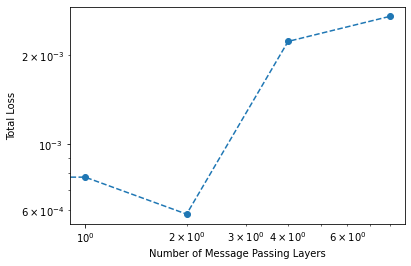

In [17]:
results = pd.DataFrame(results)
fig, ax = plt.subplots()
ax.loglog(results['num_layers'], results['loss'], '--o')
ax.set_xlabel('Number of Message Passing Layers')
ax.set_ylabel('Total Loss')

#### Experimenting with different readout layers for different output properties (atomization energy and bandgap)

In [18]:
# defining different loaders for atomization enregy or bandgap output

train_loader_atom = make_data_loader(file_path='datasets/train_data.proto', shuffle_buffer=1, output_property='u0_atom')
test_loader_atom = make_data_loader(file_path='datasets/test_data.proto', shuffle_buffer=1, output_property='u0_atom')
train_loader_bandgap = make_data_loader(file_path='datasets/train_data.proto', shuffle_buffer=1, output_property='bandgap')
test_loader_bandgap = make_data_loader(file_path='datasets/test_data.proto', shuffle_buffer=1, output_property='bandgap')

79/79 [==============================] - 0s 2ms/step


Text(0, 0.5, '$E_{atom}$, ML (Ha)')

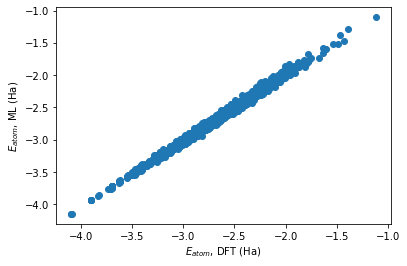

In [19]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# fitting four models: each with four layers + 64 features but changing output property + readout function

# first model: u0_atom w/ sum function (SUM BETTER FOR ATOMIZATION ENERGY)
model = make_model(64, 4, 'sum')
model.compile(loss = 'mean_squared_error')

# preseeding values for scaling layer
scale = model.get_layer('scaling')
scale.mean = outputs.numpy().mean()
scale.std = outputs.numpy().std()

# fitting model
model.fit(train_loader_atom, epochs=128, batch_size=32, callbacks=callback, verbose=False)
y_true = np.hstack([x[1] for x in test_loader_atom])  # Pulls data out of the data loader

# predicting atomization energy using trained model
y_pred = model.predict(test_loader_atom)

# plotting predicted vs. actual values
fig, ax = plt.subplots()
ax.scatter(y_pred, y_true)
ax.set_xlabel('$E_{atom}$, DFT (Ha)')
ax.set_ylabel('$E_{atom}$, ML (Ha)')

79/79 [==============================] - 0s 2ms/step


Text(0, 0.5, '$E_{atom}$, ML (Ha)')

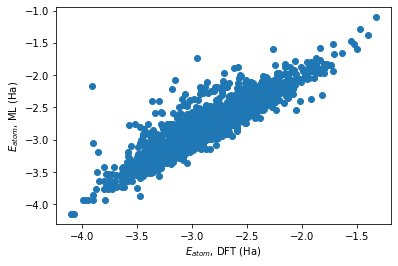

In [20]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# second model: u0_atom with max readout function

model = make_model(64, 4, 'max')
model.compile(loss = 'mean_squared_error')

# preseeding values for scaling layer
scale = model.get_layer('scaling')
scale.mean = outputs.numpy().mean()
scale.std = outputs.numpy().std()

# fitting model
model.fit(train_loader_atom, epochs=128, batch_size=32, callbacks=callback, verbose=False)
y_true = np.hstack([x[1] for x in test_loader_atom])  # Pulls data out of the data loader

# predicting atomization energy using trained model
y_pred = model.predict(test_loader_atom)

# plotting predicted vs. actual values
fig, ax = plt.subplots()
ax.scatter(y_pred, y_true)
ax.set_xlabel('$E_{atom}$, DFT (Ha)')
ax.set_ylabel('$E_{atom}$, ML (Ha)')

79/79 [==============================] - 0s 2ms/step


Text(0, 0.5, '$E_{atom}$, ML (Ha)')

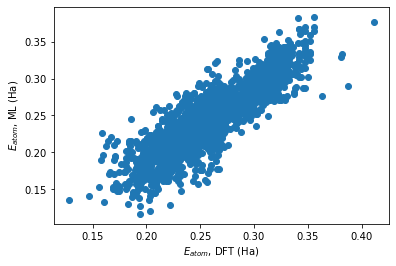

In [21]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# third model: bandgap with sum readout function

model = make_model(64, 4, 'sum')
model.compile(loss = 'mean_squared_error')

# preseeding values for scaling layer
scale = model.get_layer('scaling')
scale.mean = outputs.numpy().mean()
scale.std = outputs.numpy().std()

# fitting model
model.fit(train_loader_bandgap, epochs=128, batch_size=32, callbacks=callback, verbose=False)
y_true = np.hstack([x[1] for x in test_loader_bandgap])  # Pulls data out of the data loader

# predicting bandgap energy using trained model
y_pred = model.predict(test_loader_bandgap)

# plotting predicted vs. actual values
fig, ax = plt.subplots()
ax.scatter(y_pred, y_true)
ax.set_xlabel('$E_{atom}$, DFT (Ha)')
ax.set_ylabel('$E_{atom}$, ML (Ha)')

79/79 [==============================] - 0s 2ms/step


Text(0, 0.5, '$E_{atom}$, ML (Ha)')

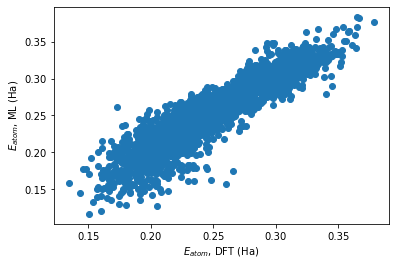

In [22]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# fourth model: bandgap with max readout function (SLIGHTLY BETTER THAN SUM)

model = make_model(64, 4, 'max')
model.compile(loss = 'mean_squared_error')

# preseeding values for scaling layer
scale = model.get_layer('scaling')
scale.mean = outputs.numpy().mean()
scale.std = outputs.numpy().std()

# fitting model
model.fit(train_loader_bandgap, epochs=128, batch_size=32, callbacks=callback, verbose=False)
y_true = np.hstack([x[1] for x in test_loader_bandgap])  # Pulls data out of the data loader

# predicting bandgap energy using trained model
y_pred = model.predict(test_loader_bandgap)

# plotting predicted vs. actual values
fig, ax = plt.subplots()
ax.scatter(y_pred, y_true)
ax.set_xlabel('$E_{atom}$, DFT (Ha)')
ax.set_ylabel('$E_{atom}$, ML (Ha)')

#### Conclusions: 

1. MAX readout functions cannot scale with molecule size because it only considers the largest atomization energy of a molecule regardless of size. This particular readout function considers all features in equal significance as a result and will not correlate effectively with molecule size. Due to its size invariance, the max readout function is not dependant on the total number of features in the dataset and instead provides a fixed-size representation independent of dataset size. 

2. The sum readout function performs better for atomization energy because as a molecule's size increases, the sum of the atomization energies also increases as well, resulting in a very accurate model. For bandgap, however, the max readout function performs slightly better than the sum because bandgap energies, unlike atomization energies, cannot be scaled up because it depends on the molecular interactions between two particular atoms, one in the highest occupied orbital and one in the lowest occupied orbital, so the sum readout function isn't as effective for bandgap. 